In [1]:
import numpy as np
import pandas as pd
import pickle
import smogn

import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [2]:
df = pd.read_csv(r"C:\Users\fabian\Downloads\parklane_combined_edited.csv")
print('Unfiltered row of dataframe is {}'.format(len(df)))

Unfiltered row of dataframe is 727657


### This notebook focus will be on predicting ch_sysef using various features and some selections of models

C:\Users\fabian\AppData\Local\Temp\ipykernel_25496\1108434249.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_df['sys_eff'] = fil_df['sys_eff'] - fil_df['air_eff']


total number of rows after filter is 210699


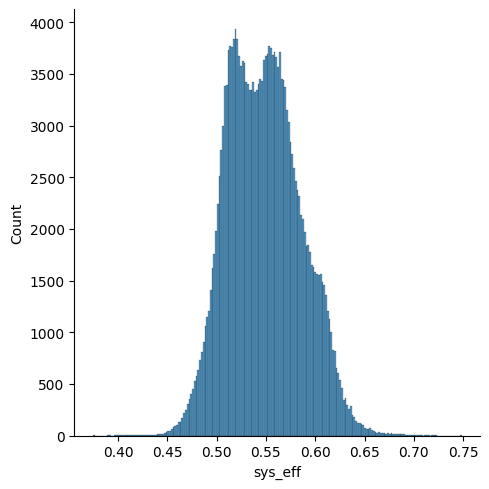

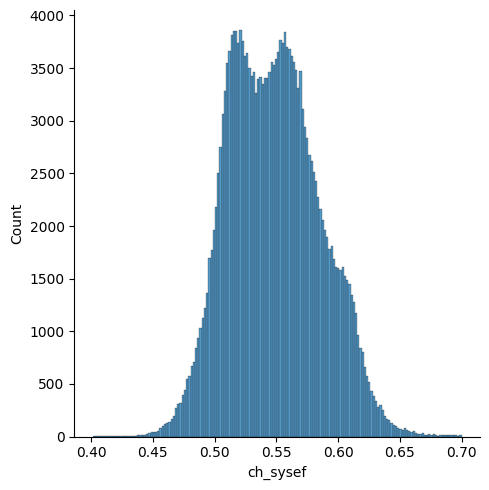

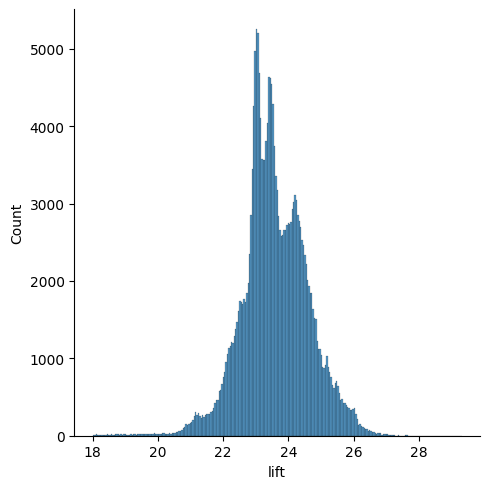

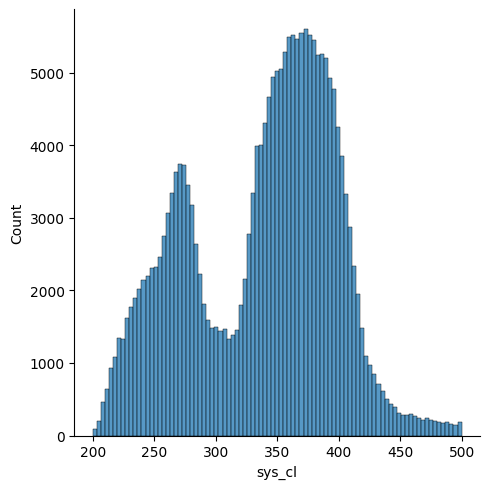

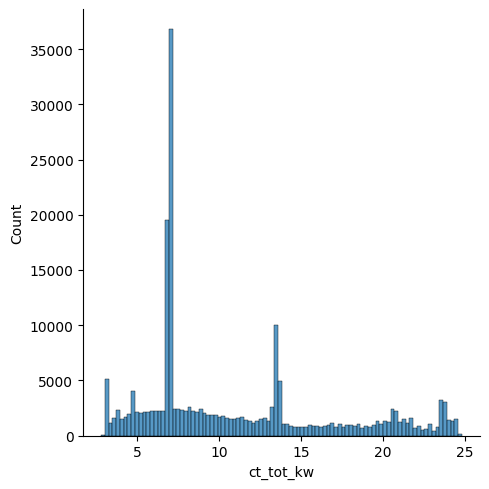

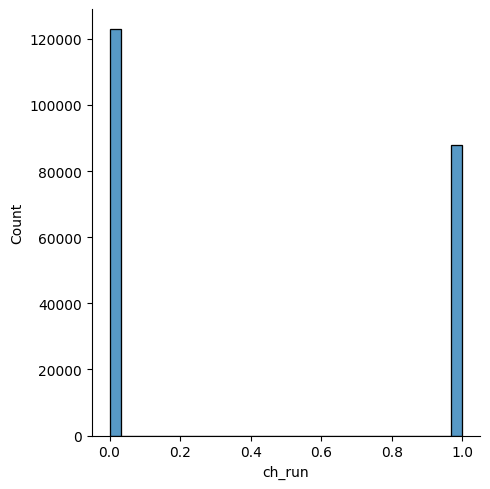

In [3]:
# filter where hr or hb is  not 0
df = df[(df['sys_hr'] != 0) | (df['sys_hb'] != 0)]
df = df[(df['h_chwst'] >=5) & (df['h_chwst'] <=20)]
df = df[(df['h_chwrt'] >=5) & (df['h_chwrt'] <=25)]
df = df[(df['pchwp_1_kw'] >=1.2) & (df['pchwp_1_kw'] <=5)]
# unsure of pchwp_2 kw filtering
#df = df[(df['pchwp_2_kw'] >=1.2) & (df['pchwp_2_kw'] <=5)]
df = df[(df['h_chwf'] >= 0) & (df['h_chwf'] <= 1500)]
df = df[(df['cwp_1_kw'] > 0) & (df['cwp_1_kw'] <=25)]
df = df[(df['cwp_2_kw'] > 0) & (df['cwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >0) & (df['h_chwf'] <=1500)]
df = df[(df['h_cwst']>=20) & (df['h_cwst']<=32)]
df = df[(df['h_cwrt']>=20) & (df['h_cwrt']<=40)]
df = df[(df['ch_1_kwe']>=0) & (df['ch_1_kwe']<=350)]
df = df[(df['ch_2_kwe']>=0) & (df['ch_2_kwe']<=350)]
df = df[(df['ct_1_kw']>=0) & (df['ct_1_kw']<=15)]
df = df[(df['ct_2_kw']>=0) & (df['ct_2_kw']<=15)]
df = df[(df['sys_cl']>=200) & (df['sys_cl']<=500)]
df = df[(df['sys_hr']>0) & (df['sys_hr']<=1000)]
df = df[(df['sys_kw']>0) & (df['sys_kw']<=400)]
fil_df = df[(df['ch_sysef']>=0.4) & (df['ch_sysef']<=0.7) & (df['sys_eff']>=0.4) & (df['sys_eff']<=0.9)]

# efficiency column reduce by air system efficiency
fil_df['sys_eff'] = fil_df['sys_eff'] - fil_df['air_eff']
# replace NaN values with 0? median imputation
fil_df = fil_df.fillna(0)

# creating Lift Column, Lift: [h_cwrt-h_chwst]
fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']
# both chillers running
fil_df['ch_run'] = (fil_df['ch_1_kwe']>=2) & (fil_df['ch_2_kwe']>=2)
fil_df['ch_run'] = fil_df['ch_run'].astype(int)

# filtering additional columns
fil_df = fil_df[(fil_df['ct_tot_kw']>=2) & (fil_df['ct_tot_kw']<=30)]
fil_df = fil_df[(fil_df['lift']>=18) & (fil_df['lift']<=30)]

print("total number of rows after filter is {}".format(len(fil_df)))

# selecting related features only
ch_sysef_df = fil_df[['sys_eff', 'ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw', 'ch_run', 'h_cwst']]
# reset
ch_sysef_df = ch_sysef_df.reset_index()

# distribution
sns.displot(ch_sysef_df, x="sys_eff")
sns.displot(ch_sysef_df, x="ch_sysef")
sns.displot(ch_sysef_df, x="lift")
sns.displot(ch_sysef_df, x="sys_cl")
sns.displot(ch_sysef_df, x="ct_tot_kw")
sns.displot(ch_sysef_df, x="ch_run")

In [4]:
saved_df = ch_sysef_df.drop("ch_run", axis=1)
saved_df = saved_df[:1000]
saved_df.to_csv("train.csv", index=False)
saved_df.head(5)

index   sys_eff  ch_sysef       lift      sys_cl  ct_tot_kw     h_cwst
0    646  0.498156  0.497447  19.139454  352.233795   7.056000  26.070417
1    648  0.553833  0.550988  18.783153  349.504547   7.088001  26.830719
2    649  0.569575  0.570091  19.933795  360.257111   7.104001  27.225933
3    650  0.567483  0.570109  20.829254  370.950195   7.072001  27.347572
4    651  0.573581  0.572669  21.348466  374.542725   7.056001  27.346157

## Training

In [5]:
# train_test split
X = ch_sysef_df[['lift', 'sys_cl', 'ct_tot_kw', 'ch_run']]
y = ch_sysef_df[['ch_sysef']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
y.transpose()

# Training
max_depth = [100, 500]
min_samples_splits = [10, 50, 100]
no_of_trees = [100, 200, 500]
min_samples_leafs = [10, 50, 100]
ccp_alphas = [1, 5, 10]

parameter_grid = {
    'max_depth': max_depth,
    'min_samples_split': min_samples_splits,
    'min_samples_leaf': min_samples_leafs,
    'n_estimators': no_of_trees,
    'ccp_alpha': ccp_alphas,
    'random_state': [10],

}

grid_search = GridSearchCV(
    estimator= RandomForestRegressor(warm_start=True, bootstrap=True, n_jobs=-1),
    param_grid=parameter_grid,
    cv=3
)

regr = RandomForestRegressor()
grid_search.fit(X_train, y_train)

## save model
filename = 'RF_optimized_both_ch.sav'
pickle.dump(grid_search, open(filename, 'wb'))

c:\Users\fabian\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\fabian\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\fabian\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\fabian\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

In [6]:
# train_test split
X = ch_sysef_df[['lift', 'sys_cl', 'ct_tot_kw', 'ch_run', 'h_cwst']]
y = ch_sysef_df[['ch_sysef']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
y.transpose()

# Training
max_depth = [100, 500]
min_samples_splits = [10, 50, 100]
no_of_trees = [100, 200, 500]
min_samples_leafs = [10, 50, 100]
ccp_alphas = [1, 5, 10]
max_features = ['1', 'sqrt']

parameter_grid = {
    'max_depth': max_depth,
    'min_samples_split': min_samples_splits,
    'min_samples_leaf': min_samples_leafs,
    'n_estimators': no_of_trees,
    'ccp_alpha': ccp_alphas,
    'random_state': [10],
    'max_features': max_features

}

grid_search = GridSearchCV(
    estimator= RandomForestRegressor(warm_start=True, bootstrap=True, n_jobs=-1),
    param_grid=parameter_grid,
    cv=5
)

grid_search.fit(X_train, y_train)

## save model
filename = 'RF_optimized_both_ch_h_cwst.sav'
pickle.dump(grid_search, open(filename, 'wb'))

c:\Users\fabian\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\fabian\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\fabian\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\fabian\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

In [23]:
import pickle
model = pickle.load(open(r"C:\Users\fabian\Desktop\optimization\optimization\parklane\RF_first_both_ch.sav", 'rb'))

model.predict([[23.32, 400, 5, 1]])

c:\Users\fabian\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([0.54032224])